In [0]:
!rm -rf sample_data

In [0]:
# helper functions for pulling in data to colabs

def get_files_by_folder_id(folder_id, drive):
  return drive.ListFile({'q': "'{}' in parents".format(folder_id)}).GetList()

def is_folder_prefix(folder_name, folders):
    return any(map(lambda x: x.startswith(folder_name), folders))

#recursively build the file directory at download_path for folder with download_id on drive
def build_file_directory(download_path, download_id, drive, folders=None):
  try:
    os.makedirs(download_path)
    print('created', download_path)
  except: 
    print('failed to create', download_path)

  file_list = get_files_by_folder_id(download_id, drive)
  
  for f in file_list:
    if f['mimeType'] == 'application/vnd.google-apps.folder':
      #print(folders)
      sub_download_path = download_path + '/' + f['title']
      #print(sub_download_path)
      
      #if sub_download_path is a prefix for any string in required folders, must explore
      if folders is None or is_folder_prefix(sub_download_path, folders):
        build_file_directory(download_path + '/' + f['title'], f['id'], drive, folders)
    else:
      #add files if the file is in a required folder (given by download_path)
      if download_path in folders:
       #print('title: %s, id: %s' % (f['title'], f['id']))
       fname = os.path.join(download_path, f['title'])
       #print('downloading to {}'.format(fname))
       f_ = drive.CreateFile({'id': f['id']})
       f_.GetContentFile(fname)
    
      
    
  

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [28]:
# choose a local (colab) directory to store the data.
local_root = '/content/models'

local_download_path = os.path.expanduser(local_root)

#specify model imports we actually want
required_folders = ['official/mnist', 'research/gan/mnist', 'research/slim/datasets', 'research/gan/mnist/data',
                   'numpy']
required_local_paths = [local_root + '/' + folder_name for folder_name in required_folders]

print(required_local_paths)

['/content/models/official/mnist', '/content/models/research/gan/mnist', '/content/models/research/slim/datasets', '/content/models/research/gan/mnist/data', '/content/models/numpy']


In [29]:
#given id corresponds to models
build_file_directory(local_download_path, '17t5nYVve2Amzh1Rty5NnXsTQ2-1d9K6c', drive, required_local_paths)

failed to create /content/models
failed to create /content/models/numpy
failed to create /content/models/official
failed to create /content/models/official/mnist
failed to create /content/models/research
failed to create /content/models/research/gan
failed to create /content/models/research/gan/mnist
failed to create /content/models/research/gan/mnist/data
failed to create /content/models/research/slim
failed to create /content/models/research/slim/datasets


In [30]:
default_path = 'models/research/gan'

os.listdir()
if os.getcwd() != '/content/models/research/gan':
  os.chdir(default_path)
os.listdir()

['mnist']

<a id='setup'></a>
### Setup

In [0]:
!python -c "import tensorflow.contrib.gan as tfgan"

In [0]:
# Make TFGAN models and TF-Slim models discoverable.
import sys
import os


#make sure we're in models/research/gan
#print(os.getcwd())

#os.chdir('../tf_experiment/models/research/gan')

# This is needed since the notebook is stored in the `tensorflow/models/gan` folder.
sys.path.append('..')
sys.path.append(os.path.join('..', 'slim'))

<a id='imports'></a>
### Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import functools
from six.moves import xrange  # pylint: disable=redefined-builtin

import tensorflow as tf



# Main TFGAN library.
tfgan = tf.contrib.gan

# TFGAN MNIST examples from `tensorflow/models`.
from mnist import data_provider
from mnist import util

# TF-Slim data provider.

#### need to figure out how to give shoes to this thing here vvvvvvv
from datasets import download_and_convert_mnist



# Shortcuts for later.
queues = tf.contrib.slim.queues
layers = tf.contrib.layers
ds = tf.contrib.distributions
framework = tf.contrib.framework

### Common functions

These functions are used by many examples, so we define them here.

In [0]:
leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)
  

def visualize_training_generator(train_step_num, start_time, data_np):
    """Visualize generator outputs during training.
    
    Args:
        train_step_num: The training step number. A python integer.
        start_time: Time when training started. The output of `time.time()`. A
            python float.
        data: Data to plot. A numpy array, most likely from an evaluated TensorFlow
            tensor.
    """
    print('Training step: %i' % train_step_num)
    time_since_start = (time.time() - start_time) / 60.0
    print('Time since start: %f m' % time_since_start)
    print('Steps per min: %f' % (train_step_num / time_since_start))
    plt.axis('off')
    plt.imshow(np.squeeze(data_np), cmap='gray')
    plt.show()

def visualize_digits(tensor_to_visualize):
    """Visualize an image once. Used to visualize generator before training.
    
    Args:
        tensor_to_visualize: An image tensor to visualize. A python Tensor.
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        with queues.QueueRunners(sess):
            images_np = sess.run(tensor_to_visualize)
            print('THIS SHOULD PROBABLY BE A NUMPY ARRAY:', type(images_np))
    plt.axis('off')
    plt.imshow(np.squeeze(images_np), cmap='gray')

def evaluate_tfgan_loss(gan_loss, name=None):
    """Evaluate GAN losses. Used to check that the graph is correct.
    
    Args:
        gan_loss: A GANLoss tuple.
        name: Optional. If present, append to debug output.
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        with queues.QueueRunners(sess):
            gen_loss_np = sess.run(gan_loss.generator_loss)
            dis_loss_np = sess.run(gan_loss.discriminator_loss)
    if name:
        print('%s generator loss: %f' % (name, gen_loss_np))
        print('%s discriminator loss: %f'% (name, dis_loss_np))
    else:
        print('Generator loss: %f' % gen_loss_np)
        print('Discriminator loss: %f'% dis_loss_np)

With unconditional GANs, we want a generator network to produce realistic-looking digits. During training, the generator tries to produce realistic-enough digits to 'fool' a discriminator network, while the discriminator tries to distinguish real digits from generated ones. See the paper ['NIPS 2016 Tutorial: Generative Adversarial Networks'](https://arxiv.org/pdf/1701.00160.pdf) by Goodfellow or ['Generative Adversarial Networks'](https://arxiv.org/abs/1406.2661) by Goodfellow et al. for more details.

The steps to using TFGAN to set up an unconditional GAN, in the simplest case, are as follows:

1. **Model**: Set up the generator and discriminator graphs with a [`GANModel`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L39) tuple. Use [`tfgan.gan_model`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L64) or create one manually.
1. **Losses**: Set up the generator and discriminator losses with a [`GANLoss`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L115) tuple. Use [`tfgan.gan_loss`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L328) or create one manually.
1. **Train ops**: Set up TensorFlow ops that compute the loss, calculate the gradients, and update the weights with a [`GANTrainOps`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L128) tuple. Use [`tfgan.gan_train_ops`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L476) or create one manually.
1. **Run alternating train loop**: Run the training Ops. This can be done with [`tfgan.gan_train`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L661), or done manually.

Each step can be performed by a TFGAN library call, or can be constructed manually for more control.

In [0]:
SHOE_DATA_DIR = '/content/models/numpy'

#PRESHUFFLE THE DATASET?

#PROVIDES THE BATCH TENSOR
def provide_batch(split_name, batch_size, num_epochs, data_dir):
    img_array = np.load('{}/{}_data_imgs.npy'.format(data_dir, split_name)).astype(np.float32)
    lbl_array = np.load('{}/{}_data_lbls.npy'.format(data_dir, split_name)).astype(np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((img_array, lbl_array))
    dataset = dataset.repeat(num_epochs)
    
    #set drop_remainder to True to force shape of tensor to have size 32 :)
    #(AND THEREFORE ACT LIKE THIS NOTEBOOK WAS BEFORE :))
    return dataset.batch(batch_size, drop_remainder=True).make_one_shot_iterator()    

In [0]:
#CHECK WE GET THE ITERATOR CORRECTLY

iterator =  provide_batch('train', 32, 1, SHOE_DATA_DIR)

<a id='unconditional_input'></a>
## Data input pipeline

THIS SHOULD PROBABLY BE A NUMPY ARRAY: <class 'numpy.ndarray'>


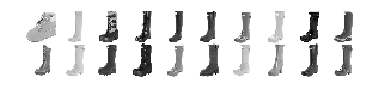

In [37]:
tf.reset_default_graph()

# Define our input pipeline. Pin it to the CPU so that the GPU can be reserved
# for forward and backwards propogation.
batch_size = 32
with tf.device('/cpu:0'):
    #dataset = provide_shoe_data('train', batch_size, SHOE_DATA_DIR)._dataset
    #real_images, _, _ = shoe_data_provider.provide_data('train', batch_size, SHOE_DATA_DIR)
    iterator = provide_batch('train', batch_size, 100, SHOE_DATA_DIR)
    
    real_images = iterator.get_next()[0]

# Sanity check that we're getting images.
check_real_digits = tfgan.eval.image_reshaper(
    real_images[:20,...], num_cols=10)
visualize_digits(check_real_digits)

In [0]:
# should shuffle the data... it's way too similar lookin' 

In [39]:
real_images

<tf.Tensor 'IteratorGetNext:0' shape=(32, 28, 28, 1) dtype=float32>

<a id='unconditional_model'></a>
## Model

Set up a [GANModel tuple](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L39), which defines everything we need to perform GAN training. You can create the tuple with the library functions, or you can manually create one.

Define the GANModel tuple using the TFGAN library function.
For the simplest case, we need the following:

1. A generator function that takes input noise and outputs generated MNIST digits

1. A discriminator function that takes images and outputs a probability of  being real or fake

1. Real images

1. A noise vector to pass to the generator

### Generator

In [0]:
def generator_fn(noise, weight_decay=2.5e-5, is_training=True):
    """Simple generator to produce MNIST images.
    
    Args:
        noise: A single Tensor representing noise.
        weight_decay: The value of the l2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        A generated image in the range [-1, 1].
    """
    with framework.arg_scope(
        [layers.fully_connected, layers.conv2d_transpose],
        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
        weights_regularizer=layers.l2_regularizer(weight_decay)),\
    framework.arg_scope([layers.batch_norm], is_training=is_training,
                        zero_debias_moving_mean=True):
        net = layers.fully_connected(noise, 1024)
        net = layers.fully_connected(net, 7 * 7 * 256)
        net = tf.reshape(net, [-1, 7, 7, 256])
        net = layers.conv2d_transpose(net, 64, [4, 4], stride=2)
        net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
        # Make sure that generator output is in the same range as `inputs`
        # ie [-1, 1].
        net = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)

        return net

### Discriminator

In [0]:
def discriminator_fn(img, unused_conditioning, weight_decay=2.5e-5,
                     is_training=True):
    """Discriminator network on MNIST digits.
    
    Args:
        img: Real or generated MNIST digits. Should be in the range [-1, 1].
        unused_conditioning: The TFGAN API can help with conditional GANs, which
            would require extra `condition` information to both the generator and the
            discriminator. Since this example is not conditional, we do not use this
            argument.
        weight_decay: The L2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        Logits for the probability that the image is real.
    """
    with framework.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.conv2d(img, 64, [4, 4], stride=2)
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        net = layers.flatten(net)
        with framework.arg_scope([layers.batch_norm], is_training=is_training):
            net = layers.fully_connected(net, 1024, normalizer_fn=layers.batch_norm)
        return layers.linear(net, 1)

### GANModel Tuple

THIS SHOULD PROBABLY BE A NUMPY ARRAY: <class 'numpy.ndarray'>


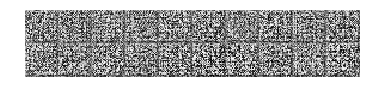

In [42]:
noise_dims = 64

#this is where the real_data gets passed in (As a tensor)


##### PROBLEM WITH PASSING DISCRIMINATOR ARGUMENTS... APPARENTLY SPECIFIED INT_64??
gan_model = tfgan.gan_model(
    generator_fn,
    discriminator_fn,
    real_data=real_images,
    generator_inputs=tf.random_normal([batch_size, noise_dims]))

# Sanity check that generated images before training are garbage.
check_generated_digits = tfgan.eval.image_reshaper(
    gan_model.generated_data[:20,...], num_cols=10)
visualize_digits(check_generated_digits)

<a id='unconditional_loss'></a>
## Losses

We next set up the GAN model losses.

Loss functions are currently an active area of research. The [losses library](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/losses/python/losses_impl.py) provides some well-known or successful loss functions, such as the [original minimax](https://arxiv.org/abs/1406.2661), [Wasserstein](https://arxiv.org/abs/1701.07875) (by Arjovsky et al), and [improved Wasserstein](https://arxiv.org/abs/1704.00028) (by Gulrajani et al) losses. It is easy to add loss functions to the library as they are developed, and you can also pass in a custom loss function.

In [43]:
# We can use the minimax loss from the original paper.
vanilla_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=tfgan.losses.minimax_generator_loss,
    discriminator_loss_fn=tfgan.losses.minimax_discriminator_loss)

# We can use the Wasserstein loss (https://arxiv.org/abs/1701.07875) with the 
# gradient penalty from the improved Wasserstein loss paper 
# (https://arxiv.org/abs/1704.00028).
improved_wgan_loss = tfgan.gan_loss(
    gan_model,
    # We make the loss explicit for demonstration, even though the default is 
    # Wasserstein loss.
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    gradient_penalty_weight=1.0)

# We can also define custom losses to use with the rest of the TFGAN framework.
def silly_custom_generator_loss(gan_model, add_summaries=False):
    return tf.reduce_mean(gan_model.discriminator_gen_outputs)
def silly_custom_discriminator_loss(gan_model, add_summaries=False):
    return (tf.reduce_mean(gan_model.discriminator_gen_outputs) -
            tf.reduce_mean(gan_model.discriminator_real_outputs))
custom_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=silly_custom_generator_loss,
    discriminator_loss_fn=silly_custom_discriminator_loss)

# Sanity check that we can evaluate our losses.
for gan_loss, name in [(vanilla_gan_loss, 'vanilla loss'), 
                       (improved_wgan_loss, 'improved wgan loss'), 
                       (custom_gan_loss, 'custom loss')]:
    evaluate_tfgan_loss(gan_loss, name)

vanilla loss generator loss: -0.768739
vanilla loss discriminator loss: 1.358535
improved wgan loss generator loss: -0.033919
improved wgan loss discriminator loss: 0.080904
custom loss generator loss: -0.309987
custom loss discriminator loss: -0.115534


<a id='unconditional_train'></a>
## Training and Evaluation

### Train Ops
In order to train a GAN, we need to train both generator and discriminator networks using some variant of the alternating training paradigm. To do this, we construct a [GANTrainOps tuple](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L128) either manually or with a library call. We pass it the optimizers that we want to use, as well as any extra arguments that we'd like passed to slim's `create_train_op` function.

In [44]:
generator_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5)
gan_train_ops = tfgan.gan_train_ops(
    gan_model,
    improved_wgan_loss,
    generator_optimizer,
    discriminator_optimizer)

### Evaluation

TFGAN provides some standard methods of evaluating generative models. In this example, we use a pre-trained classifier to calculate what is called the 'Inception Score' from [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) (by Salimans et al), which is a combined score of quality and diversity. We also calculate the 'Frechet Inception distance' from [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500) (by Heusel et al), which measures how close the generated image distribution is to the real image distribution. 

### We aren't evaluating ShoeGAN just yet and this is left in for reference. Markdown'd version of evaluating MNIST. See Tutorial notebook for removed steps for MNIST to get an idea of how to evaluate ShoeGAN (will probably need to train a shoe not-shoe classifier).

In [0]:
#inception score probably just takes a classifier that already works on the right distribution 
#and sees how it does on this new distribution. Kind of like an analogy between probability
#and likelihood. The score represents... 

In [0]:
# EVALUATION: Reshape eval images for viewing.


num_images_to_eval = 32
# For variables to load, use the same variable scope as in the train job.
with tf.variable_scope('Generator', reuse=True):
    eval_images = gan_model.generator_fn(
        tf.random_normal([num_images_to_eval, noise_dims]),
        is_training=False)
    
    
generated_data_to_visualize = tfgan.eval.image_reshaper(
    eval_images[:20,...], num_cols=10)

### Train Steps

Now we're ready to train. TFGAN handles the alternating training scheme that arises from the GAN minmax game. It also gives you the option of changing the ratio of discriminator updates to generator updates. Most applications (distributed setting, borg, etc) will use the [`gan_train`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L661) function, but we will use a different TFGAN utility and manually run the train ops so we can introspect more.

This code block should take about **1 minute** to run on a GPU kernel, and about **8 minutes** on CPU.

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Current loss: 0.620331
Training step: 0
Time since start: 0.026667 m
Steps per min: 0.000000


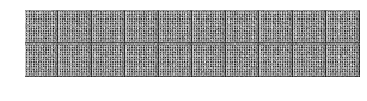

Current loss: -3.426077
Training step: 200
Time since start: 0.194959 m
Steps per min: 1025.855836


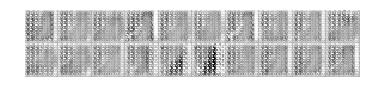

Current loss: -0.686178
Training step: 400
Time since start: 0.360461 m
Steps per min: 1109.690200


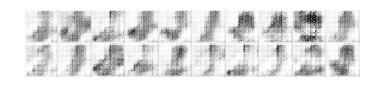

Current loss: 0.066444
Training step: 600
Time since start: 0.530260 m
Steps per min: 1131.521263


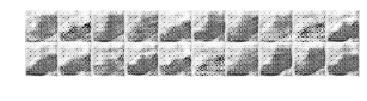

Current loss: 0.347512
Training step: 800
Time since start: 0.692068 m
Steps per min: 1155.955646


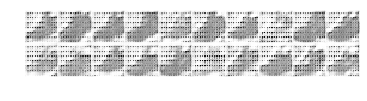

Current loss: 0.395002
Training step: 1000
Time since start: 0.857380 m
Steps per min: 1166.343501


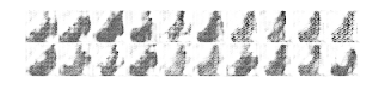

Current loss: 1.045544
Training step: 1200
Time since start: 1.022868 m
Steps per min: 1173.171721


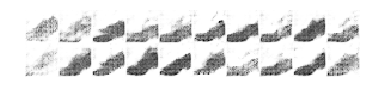

Current loss: -3.373353
Training step: 1400
Time since start: 1.192230 m
Steps per min: 1174.270322


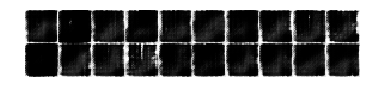

Current loss: -1.791417
Training step: 1600
Time since start: 1.355707 m
Steps per min: 1180.196198


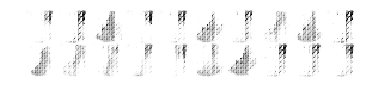

Current loss: 0.099325
Training step: 1800
Time since start: 1.522014 m
Steps per min: 1182.643439


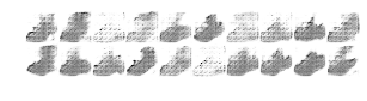

Current loss: -0.056288
Training step: 2000
Time since start: 1.687211 m
Steps per min: 1185.388403


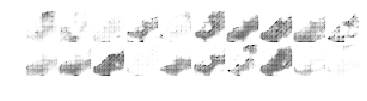

Current loss: 0.048862
Training step: 2200
Time since start: 1.856390 m
Steps per min: 1185.095734


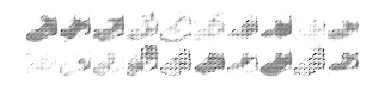

Current loss: -0.005209
Training step: 2400
Time since start: 2.019716 m
Steps per min: 1188.286060


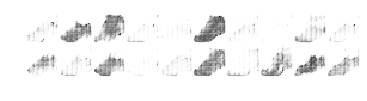

Current loss: 0.201194
Training step: 2600
Time since start: 2.185478 m
Steps per min: 1189.671015


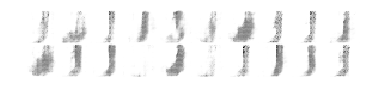

Current loss: -0.236180
Training step: 2800
Time since start: 2.351094 m
Steps per min: 1190.935062


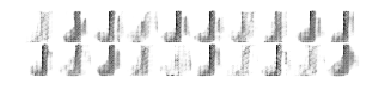

Current loss: 0.511907
Training step: 3000
Time since start: 2.521373 m
Steps per min: 1189.828080


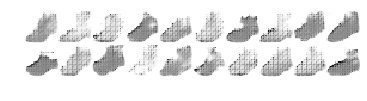

Current loss: -0.019102
Training step: 3200
Time since start: 2.684997 m
Steps per min: 1191.807602


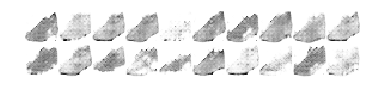

Current loss: -0.410731
Training step: 3400
Time since start: 2.850628 m
Steps per min: 1192.719598


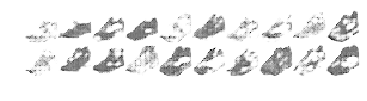

Current loss: -0.683629
Training step: 3600
Time since start: 3.016499 m
Steps per min: 1193.436534


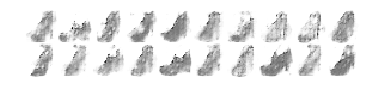

Current loss: -0.363546
Training step: 3800
Time since start: 3.186451 m
Steps per min: 1192.549241


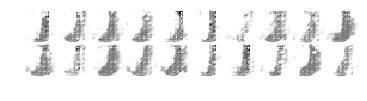

Current loss: 0.046794
Training step: 4000
Time since start: 3.349977 m
Steps per min: 1194.038118


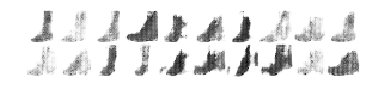

Current loss: 0.241725
Training step: 4200
Time since start: 3.516462 m
Steps per min: 1194.382157


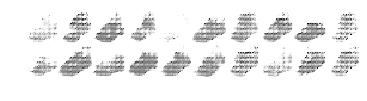

Current loss: -0.906064
Training step: 4400
Time since start: 3.682536 m
Steps per min: 1194.828923


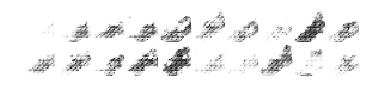

Current loss: 0.205726
Training step: 4600
Time since start: 3.852270 m
Steps per min: 1194.101261


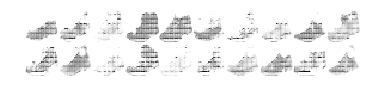

Current loss: 0.080487
Training step: 4800
Time since start: 4.015924 m
Steps per min: 1195.241597


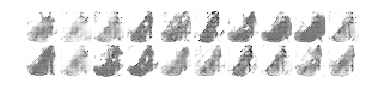

Current loss: -0.312608
Training step: 5000
Time since start: 4.182003 m
Steps per min: 1195.599456


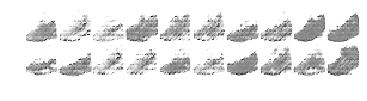

Current loss: -0.112545
Training step: 5200
Time since start: 4.345993 m
Steps per min: 1196.504474


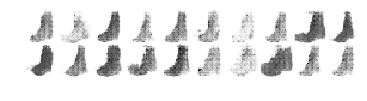

Current loss: 0.092420
Training step: 5400
Time since start: 4.516309 m
Steps per min: 1195.666768


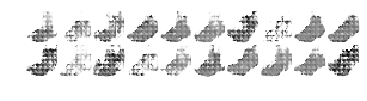

Current loss: 0.130989
Training step: 5600
Time since start: 4.678271 m
Steps per min: 1197.023487


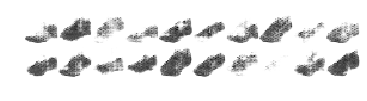

Current loss: -0.456960
Training step: 5800
Time since start: 4.844412 m
Steps per min: 1197.255627


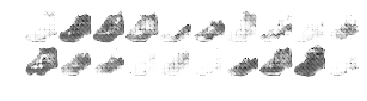

Current loss: -0.248061
Training step: 6000
Time since start: 5.010280 m
Steps per min: 1197.537842


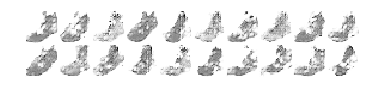

Current loss: 0.156267
Training step: 6200
Time since start: 5.179981 m
Steps per min: 1196.915583


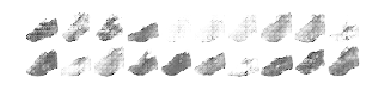

Current loss: -0.262859
Training step: 6400
Time since start: 5.343223 m
Steps per min: 1197.778925


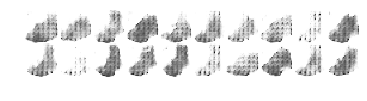

Current loss: -0.066279
Training step: 6600
Time since start: 5.508621 m
Steps per min: 1198.121899


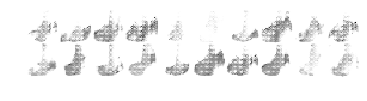

Current loss: -0.208433
Training step: 6800
Time since start: 5.674341 m
Steps per min: 1198.377101


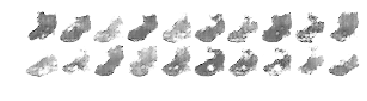

Current loss: 0.258671
Training step: 7000
Time since start: 5.842336 m
Steps per min: 1198.150978


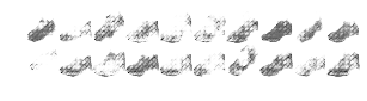

Current loss: 0.494462
Training step: 7200
Time since start: 6.003944 m
Steps per min: 1199.211660


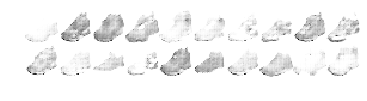

Current loss: -1.198242
Training step: 7400
Time since start: 6.169748 m
Steps per min: 1199.400738


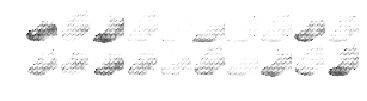

Current loss: -0.419831
Training step: 7600
Time since start: 6.335893 m
Steps per min: 1199.515152


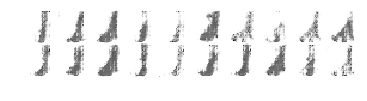

Current loss: -0.337252
Training step: 7800
Time since start: 6.505287 m
Steps per min: 1199.024708


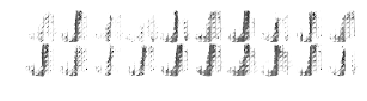

Current loss: 0.119142
Training step: 8000
Time since start: 6.668824 m
Steps per min: 1199.611833


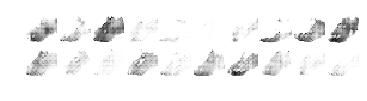

Current loss: -0.049935
Training step: 8200
Time since start: 6.834468 m
Steps per min: 1199.800694


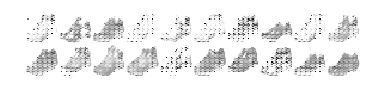

Current loss: -0.327099
Training step: 8400
Time since start: 7.000129 m
Steps per min: 1199.977868


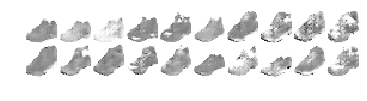

Current loss: -1.100065
Training step: 8600
Time since start: 7.169227 m
Steps per min: 1199.571386


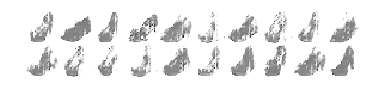

Current loss: -0.788484
Training step: 8800
Time since start: 7.332558 m
Steps per min: 1200.126871


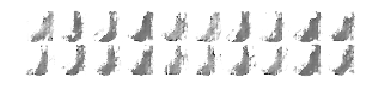

Current loss: 0.385083
Training step: 9000
Time since start: 7.498727 m
Steps per min: 1200.203771


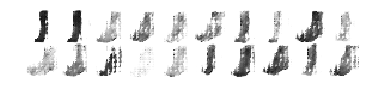

Current loss: -0.234799
Training step: 9200
Time since start: 7.664692 m
Steps per min: 1200.309170


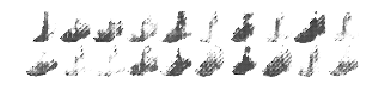

Current loss: 0.204894
Training step: 9400
Time since start: 7.834322 m
Steps per min: 1199.848580


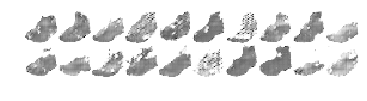

Current loss: -0.052946
Training step: 9600
Time since start: 7.997970 m
Steps per min: 1200.304622


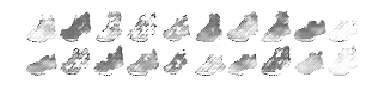

Current loss: -0.369841
Training step: 9800
Time since start: 8.163918 m
Steps per min: 1200.404040


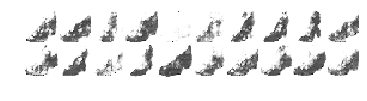

Current loss: 0.156552
Training step: 10000
Time since start: 8.329302 m
Steps per min: 1200.580742


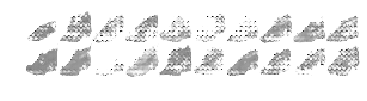

Current loss: 0.288748
Training step: 10200
Time since start: 8.499411 m
Steps per min: 1200.083117


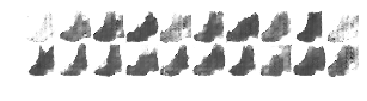

Current loss: 0.241753
Training step: 10400
Time since start: 8.663131 m
Steps per min: 1200.489803


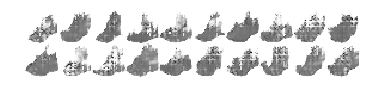

Current loss: -0.550460
Training step: 10600
Time since start: 8.828996 m
Steps per min: 1200.589489


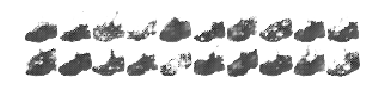

Current loss: 0.654595
Training step: 10800
Time since start: 8.994832 m
Steps per min: 1200.689481


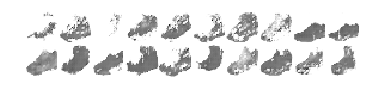

Current loss: -0.240680
Training step: 11000
Time since start: 9.164124 m
Steps per min: 1200.332893


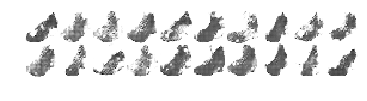

Current loss: -0.429115
Training step: 11200
Time since start: 9.327717 m
Steps per min: 1200.722486


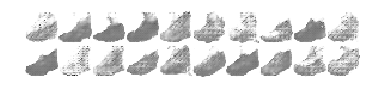

Current loss: -0.111263
Training step: 11400
Time since start: 9.493778 m
Steps per min: 1200.786510


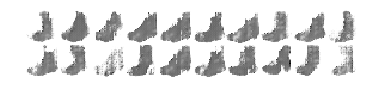

Current loss: -0.356323
Training step: 11600
Time since start: 9.659457 m
Steps per min: 1200.895599


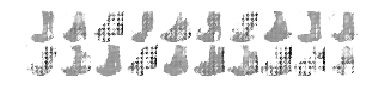

Current loss: 0.098542
Training step: 11800
Time since start: 9.827157 m
Steps per min: 1200.754180


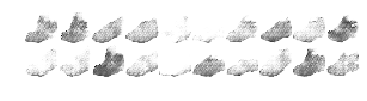

Current loss: -0.022700
Training step: 12000
Time since start: 9.990537 m
Steps per min: 1201.136618


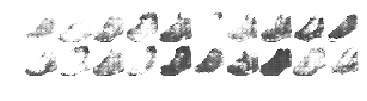

Current loss: -0.484689
Training step: 12200
Time since start: 10.156570 m
Steps per min: 1201.192864


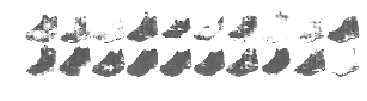

Current loss: -0.670471
Training step: 12400
Time since start: 10.322638 m
Steps per min: 1201.243379


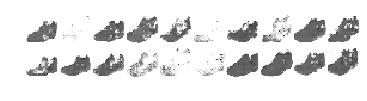

Current loss: 0.368321
Training step: 12600
Time since start: 10.492380 m
Steps per min: 1200.871442


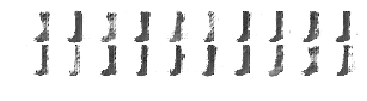

Current loss: -1.047490
Training step: 12800
Time since start: 10.655968 m
Steps per min: 1201.204806


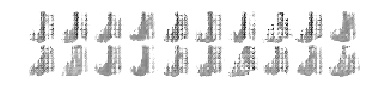

Current loss: -0.606518
Training step: 13000
Time since start: 10.822010 m
Steps per min: 1201.255564


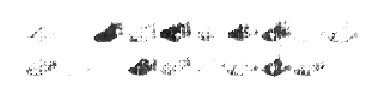

Current loss: 0.106297
Training step: 13200
Time since start: 10.986491 m
Steps per min: 1201.475543


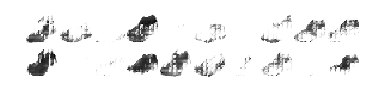

Current loss: -0.272900
Training step: 13400
Time since start: 11.153393 m
Steps per min: 1201.428096


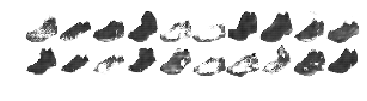

Current loss: -0.926774
Training step: 13600
Time since start: 11.317175 m
Steps per min: 1201.713371


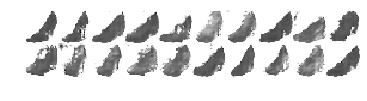

Current loss: -0.368917
Training step: 13800
Time since start: 11.483221 m
Steps per min: 1201.753369


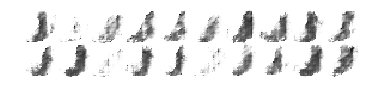

Current loss: 0.193404
Training step: 14000
Time since start: 11.648872 m
Steps per min: 1201.833091


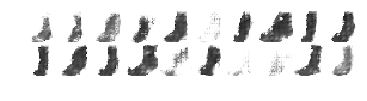

Current loss: 0.147518
Training step: 14200
Time since start: 11.818195 m
Steps per min: 1201.537165


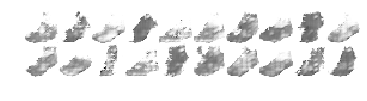

Current loss: -0.340154
Training step: 14400
Time since start: 11.987212 m
Steps per min: 1201.280144


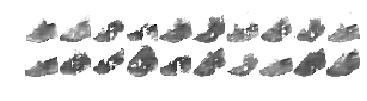

Current loss: -0.211555
Training step: 14600
Time since start: 12.153054 m
Steps per min: 1201.344100


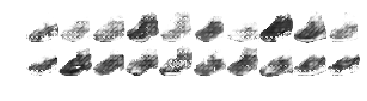

Current loss: -0.452672
Training step: 14800
Time since start: 12.318778 m
Steps per min: 1201.417866


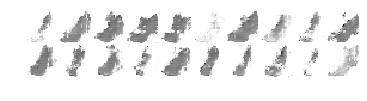

Current loss: -0.224348
Training step: 15000
Time since start: 12.488613 m
Steps per min: 1201.094113


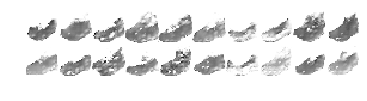

Current loss: -0.131899
Training step: 15200
Time since start: 12.652017 m
Steps per min: 1201.389447


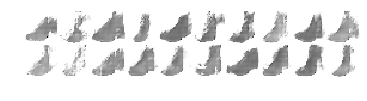

Current loss: 0.173703
Training step: 15400
Time since start: 12.817783 m
Steps per min: 1201.455808


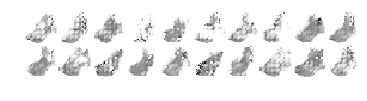

Current loss: -0.460745
Training step: 15600
Time since start: 12.983446 m
Steps per min: 1201.530011


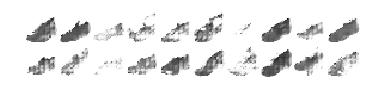

Current loss: -0.105502
Training step: 15800
Time since start: 13.153227 m
Steps per min: 1201.226102


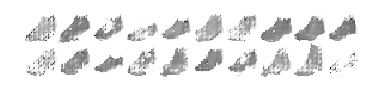

Current loss: 0.351113
Training step: 16000
Time since start: 13.316537 m
Steps per min: 1201.513571


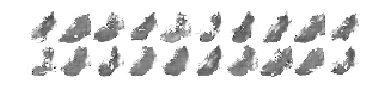

Current loss: -0.143396
Training step: 16200
Time since start: 13.482905 m
Steps per min: 1201.521512


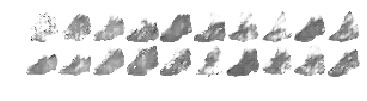

Current loss: 0.275647
Training step: 16400
Time since start: 13.648722 m
Steps per min: 1201.577690


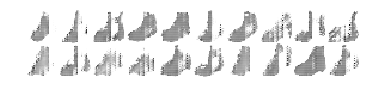

Current loss: -1.261076
Training step: 16600
Time since start: 13.818516 m
Steps per min: 1201.286760


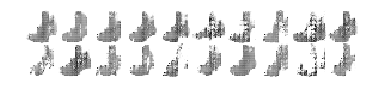

Current loss: -1.452234
Training step: 16800
Time since start: 13.982613 m
Steps per min: 1201.492202


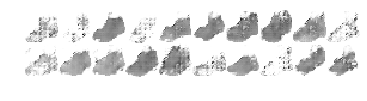

Current loss: -0.025553
Training step: 17000
Time since start: 14.148893 m
Steps per min: 1201.507385


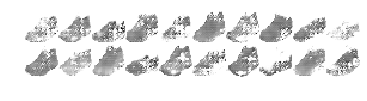

Current loss: -0.140909
Training step: 17200
Time since start: 14.314965 m
Steps per min: 1201.539754


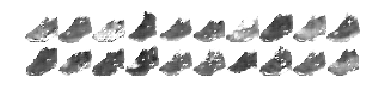

Current loss: -0.636790
Training step: 17400
Time since start: 14.484903 m
Steps per min: 1201.250717


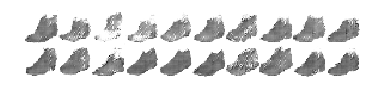

Current loss: 0.014452
Training step: 17600
Time since start: 14.648385 m
Steps per min: 1201.497600


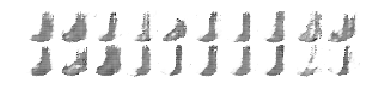

Current loss: -1.046643
Training step: 17800
Time since start: 14.813545 m
Steps per min: 1201.603001


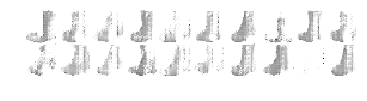

Current loss: -0.542519
Training step: 18000
Time since start: 14.978746 m
Steps per min: 1201.702761


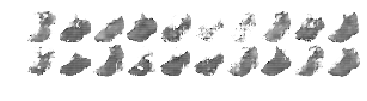

Current loss: -0.303345
Training step: 18200
Time since start: 15.148176 m
Steps per min: 1201.464776


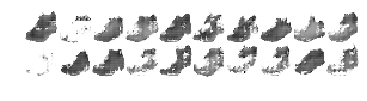

Current loss: 0.710399
Training step: 18400
Time since start: 15.311718 m
Steps per min: 1201.693988


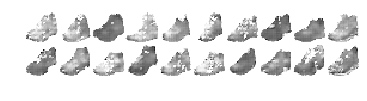

Current loss: -0.798004
Training step: 18600
Time since start: 15.477488 m
Steps per min: 1201.745375


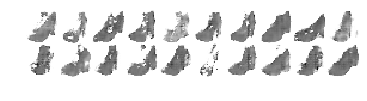

Current loss: -1.193057
Training step: 18800
Time since start: 15.642554 m
Steps per min: 1201.849794


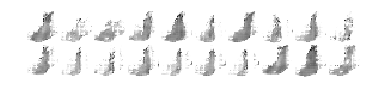

Current loss: 0.336655
Training step: 19000
Time since start: 15.811538 m
Steps per min: 1201.654106


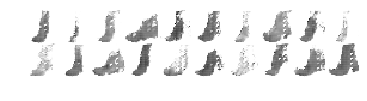

Current loss: 0.063117
Training step: 19200
Time since start: 15.975046 m
Steps per min: 1201.874473


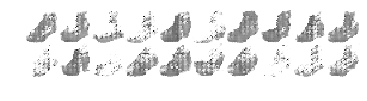

Current loss: -0.507718
Training step: 19400
Time since start: 16.140438 m
Steps per min: 1201.950070


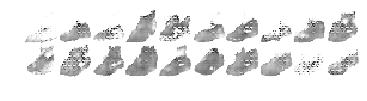

Current loss: -0.293978
Training step: 19600
Time since start: 16.303599 m
Steps per min: 1202.188557


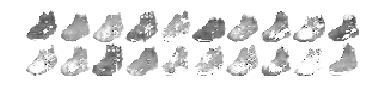

Current loss: -0.629387
Training step: 19800
Time since start: 16.473046 m
Steps per min: 1201.963481


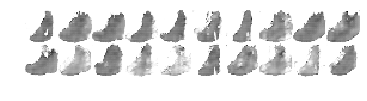

Current loss: -0.823633
Training step: 20000
Time since start: 16.636355 m
Steps per min: 1202.186402


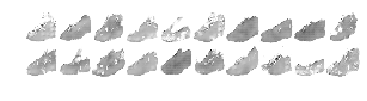

Current loss: 0.194064
Training step: 20200
Time since start: 16.802888 m
Steps per min: 1202.174262


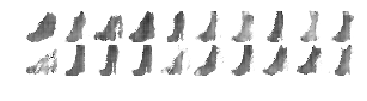

Current loss: -0.977166
Training step: 20400
Time since start: 16.968603 m
Steps per min: 1202.220349


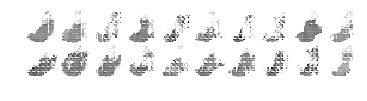

Current loss: -0.807175
Training step: 20600
Time since start: 17.137951 m
Steps per min: 1202.010702


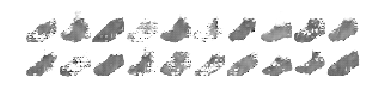

Current loss: -0.328164
Training step: 20800
Time since start: 17.301501 m
Steps per min: 1202.207834


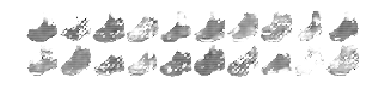

Current loss: -0.127610
Training step: 21000
Time since start: 17.467726 m
Steps per min: 1202.217197


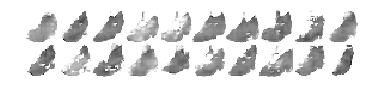

Current loss: 0.013854
Training step: 21200
Time since start: 17.633430 m
Steps per min: 1202.261864


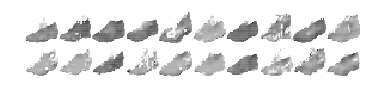

Current loss: -0.356428
Training step: 21400
Time since start: 17.802546 m
Steps per min: 1202.075224


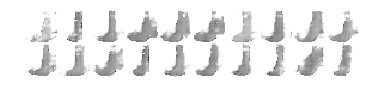

Current loss: -0.986224
Training step: 21600
Time since start: 17.965940 m
Steps per min: 1202.274956


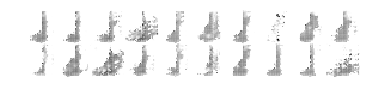

Current loss: -0.403130
Training step: 21800
Time since start: 18.132375 m
Steps per min: 1202.269398


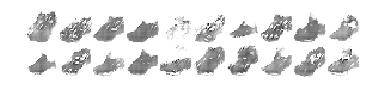

Current loss: 0.167054
Training step: 22000
Time since start: 18.298381 m
Steps per min: 1202.292147


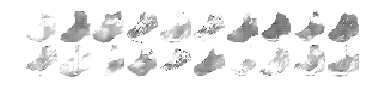

Current loss: -0.128926
Training step: 22200
Time since start: 18.468234 m
Steps per min: 1202.064044


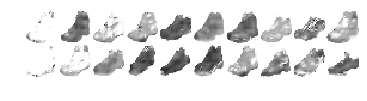

Current loss: -0.578154
Training step: 22400
Time since start: 18.631772 m
Steps per min: 1202.247456


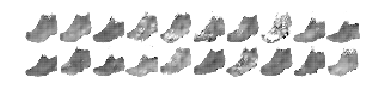

Current loss: -0.428825
Training step: 22600
Time since start: 18.797902 m
Steps per min: 1202.261810


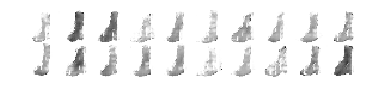

Current loss: -0.289907
Training step: 22800
Time since start: 18.963556 m
Steps per min: 1202.306136


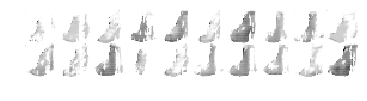

Current loss: -0.169843
Training step: 23000
Time since start: 19.133642 m
Steps per min: 1202.071221


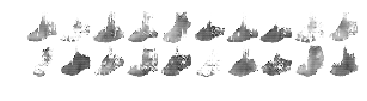

Current loss: -0.586657
Training step: 23200
Time since start: 19.297198 m
Steps per min: 1202.247075


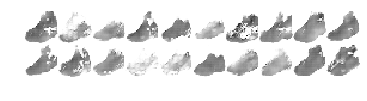

Current loss: 0.064805
Training step: 23400
Time since start: 19.463216 m
Steps per min: 1202.267936


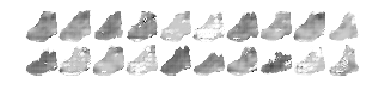

Current loss: -0.242526
Training step: 23600
Time since start: 19.629029 m
Steps per min: 1202.300914


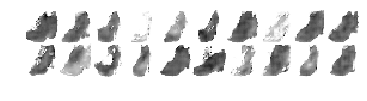

In [0]:


# We have the option to train the discriminator more than one step for every 
# step of the generator. In order to do this, we use a `GANTrainSteps` with 
# desired values. For this example, we use the default 1 generator train step 
# for every discriminator train step.
train_step_fn = tfgan.get_sequential_train_steps()

global_step = tf.train.get_or_create_global_step()
loss_values, mnist_scores, frechet_distances  = [], [], []

with tf.train.SingularMonitoredSession() as sess:
    start_time = time.time()
    for i in xrange(40000):
        cur_loss, _ = train_step_fn(
            sess, gan_train_ops, global_step, train_step_kwargs={})
        loss_values.append((i, cur_loss))
        if i % 200 == 0:
            shoes_np = sess.run([generated_data_to_visualize])
            print('Current loss: %f' % cur_loss)
            visualize_training_generator(i, start_time, shoes_np)

In [0]:
# CLEAN UP CODE... PULL FUNCTIONALITY INTO .py FILES


#### TODO:


# Get this running on colab. (Should be easy...)
    # Pull up the relevant files
    # Copy the code across
    


# ENSURE IMAGES ARE BEING SCALED BETWEEN -1 AND 1... as in... that that's what
# the network is seeing.

### TRY WITH BIGGER IMAGES and MORE COMPLEX ARCHITECTURES (hopefully you've made that first part easy for yo'self)

# BUILD SHOE SPACE and possibly PERFECT SHOE CALCULATOR (USING MEAN OF INTERESTED SHOES)